In [1]:
import pandas as pd
import numpy as np
import joblib
import os

In [3]:
# load the model from disk
model = joblib.load('./model/model.pkl')

#load the scaler
scaler = joblib.load('./model/scaler.pkl')


In [4]:
# features model expects
num_features = len(model.feature_importances_)
print(f"features_expected: {num_features}")

features_expected: 8


# Predict using a sample of data

In [5]:
raw = pd.read_csv("./data/yellow_tripdata_2020-01.csv")

C:\Users\joses\AppData\Local\Temp\ipykernel_18760\3994792170.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("./data/yellow_tripdata_2020-01.csv")


In [6]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean data by removing outliers and missing values."""
    df = df[df["passenger_count"]>0]
    df = df[df["trip_distance"]>0]
    df = df[df["fare_amount"]>0]
    df = df[df["total_amount"]>0]
    return df.reset_index()

def feature_eng(df: pd.DataFrame)-> pd.DataFrame:
    df = df.copy()
    """Create new features from existing ones.
    Transform datetime to datetime object.  
    Create new features for day of week, weekday, weeknr, hour of day, month and year."""
    
    # convert to datetime
    df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
    df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

    # create filtering features
    df = df.assign(day_of_week = df["tpep_pickup_datetime"].dt.dayofweek)
    df = df.assign(weekday = df["tpep_pickup_datetime"].dt.day_name())
    df = df.assign(weeknr = df["tpep_pickup_datetime"].dt.isocalendar().week)
    df = df.assign(hour_of_day = df["tpep_pickup_datetime"].dt.hour)
    df = df.assign(month = df["tpep_pickup_datetime"].dt.month)
    df = df.assign(year = df["tpep_pickup_datetime"].dt.year)
    df = df.sort_values(by="tpep_pickup_datetime")
    return df

In [7]:
df = raw.pipe(feature_eng).pipe(clean_data)

## Prepare data for prediction
we will predict a batch of data but we could also do it as a service for individual entering data points

In [8]:
X_cols= ["trip_distance", "passenger_count","PULocationID","DOLocationID", "RatecodeID", "hour_of_day", "day_of_week", "weeknr"]
X = df[X_cols].values


In [9]:
X = scaler.transform(X)

In [10]:
predictions=model.predict(X)

In [11]:
results = pd.DataFrame(predictions, columns=["predictions"])
results = pd.concat([results, df["total_amount"]], axis=1)

In [12]:
results

,predictions,total_amount
0,35.230389,40.70
1,6.260237,7.25
2,8.184559,10.80
3,22.138462,23.80
4,17.189941,20.30
...,...,...
6141439,12.077111,13.56
6141440,11.150964,9.30
6141441,12.882259,14.80
6141442,15.136779,15.80


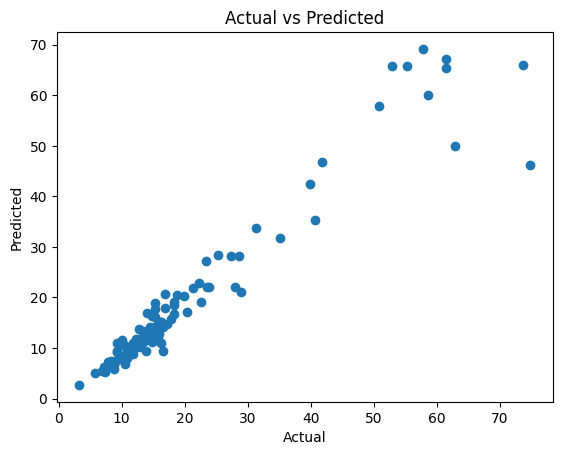

In [13]:
# Plot a sample of 100 rows
plot_df = results.iloc[0:100, :].reset_index(drop=True)
import matplotlib.pyplot as plt

plt.scatter(plot_df["total_amount"], plot_df["predictions"])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()



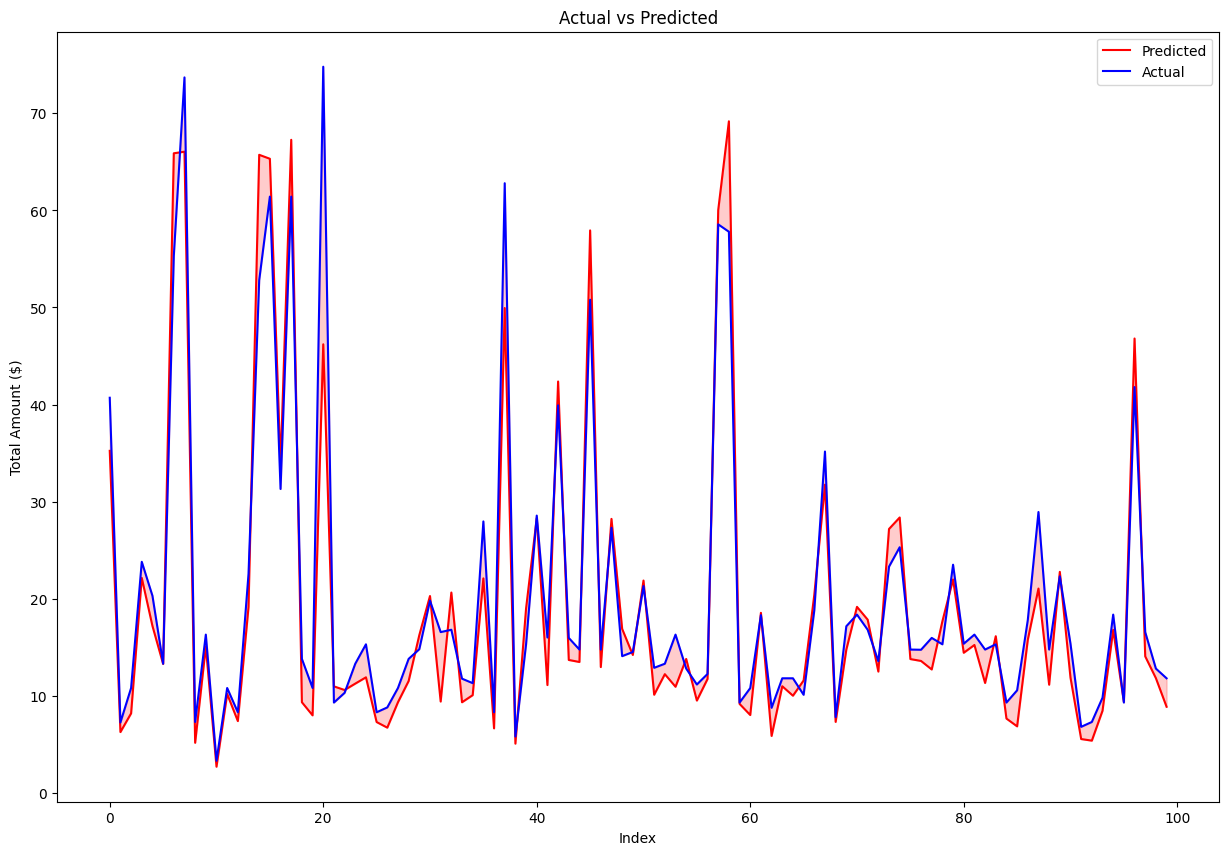

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_df["predictions"].plot(color = "red")
plot_df["total_amount"].plot(color = "blue")
ax.fill_between(plot_df.index, plot_df["predictions"], plot_df["total_amount"], color="red", alpha=0.2)
#plot in color the difference between the two
ax.set_xlabel("Index")
ax.set_ylabel("Total Amount ($)")
ax.set_title("Actual vs Predicted")
ax.legend(["Predicted", "Actual"])
plt.show()